In [27]:
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

Autosaving every 150 seconds


# Load Data

In [2]:
def load_movielens_100k():
    # Load users
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('data/ml-100k/u.user', sep='|', names=u_cols)

    # load ratings
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols)

    # Load movies
    m_cols = ['movie_id', 'title', 'release_date']
    movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

    # Join dataframes
    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


    print("The DB has "+ str(data.shape[0]) +" ratings")
    print("The DB has ", data.user_id.nunique()," users")
    print("The DB has ", data.movie_id.nunique(), " movies")
    print(data.head())
    
    return data, users, ratings, movies

def load_movielens_1M():
    # Load users
    u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv('data/ml-1m/users.dat', sep='::', names=u_cols)

    # Load ratings
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', names=r_cols)

    # Load movies
    m_cols = ['movie_id', 'title', 'release_date']
    movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

    # Join dataframes
    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


    print("The DB has "+ str(data.shape[0]) +" ratings")
    print("The DB has ", data.user_id.nunique()," users")
    print("The DB has ", data.movie_id.nunique(), " movies")
    print(data.head())
    
    return data, users, ratings, movies

# Missing value treatment

In [3]:
from sklearn.impute import KNNImputer

def impute_missing_values(df, method="mean", **params):
    if method == "mean":
        return df.mean(), df.fillna(df.mean())
    elif method == "median":
        return df.median(), df.fillna(df.median())
    elif method == "KNN":
        knnimputer = KNNImputer(**params)
        knnimputer.fit(df)
        return knnimputer, knnimputer.transform(df)  

# Item based

In [4]:
data, users, ratings, movies = load_movielens_100k()

The DB has 100000 ratings
The DB has  943  users
The DB has  1682  movies
   user_id         title  movie_id  rating release_date sex  age
0      196  Kolya (1996)       242       3  24-Jan-1997   M   49
1      305  Kolya (1996)       242       5  24-Jan-1997   M   23
2        6  Kolya (1996)       242       4  24-Jan-1997   M   42
3      234  Kolya (1996)       242       4  24-Jan-1997   M   60
4       63  Kolya (1996)       242       3  24-Jan-1997   M   31


In [13]:
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating')

_, user_item_matrix_nafilled = impute_missing_values(user_item_matrix, method="mean")

In [51]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

user_item_matrix_train = train.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix_test = test.pivot(index='user_id', columns='movie_id', values='rating')

_, user_item_matrix_train_nafilled = impute_missing_values(user_item_matrix_train, method="mean")
_, user_item_matrix_test_nafilled  = impute_missing_values(user_item_matrix_test, method="mean")

In [6]:
def slow_similarity(user_item_matrix, u1, u2, measure="cosine"):
    def dot(m, u1, u2):
        return m.loc[u1].dot(m.loc[u2])
    
    if measure == 'cosine':
        return dot(user_item_matrix, u1, u2)/(np.sqrt(dot(user_item_matrix, u1, u1)*dot(user_item_matrix, u2, u2)))
    
    elif measure == 'adj_cosine' or measure=='pearson_correlation':
        mr1 = user_item_matrix.loc[u1].mean()
        mr2 = user_item_matrix.loc[u2].mean()
        common_movies = user_item_matrix.loc[[u1,u2]].isna().sum(axis=0)==0
        common_matrix = user_item_matrix.T[common_movies].T
        return dot(common_matrix, u1, u2)/(np.sqrt(dot(common_matrix, u1, u1)*dot(common_matrix, u2, u2)))
    else:
        print("Method not implemented")
        
def fast_similarity(user_item_matrix, measure="cosine"):
    if measure == 'cosine':
        m = user_item_matrix.dot(user_item_matrix.T)
        norm = np.array([np.sqrt(np.diagonal(m))])
        return (m/norm/norm.T)
    
    elif measure == 'adj_cosine' or measure=='pearson_correlation':
        m = user_item_matrix - user_item_matrix.mean()
        m = m.dot(m.T)
        norm = np.array([np.sqrt(np.diagonal(m))])
        return (m/norm/norm.T)

In [29]:
slow_similarity(user_item_matrix_nafilled.T, 10, 11, "cosine")

0.987294941213731

In [55]:
sim_matrix = fast_similarity(user_item_matrix_nafilled.T, 'cosine')
sim_matrix.loc[10][11]

0.9872949412137292

In [32]:
def recommend_top_k(k, user_vector, user_item_matrix, measure="cosine", movies_df=movies):
    new_uim = user_item_matrix.copy()
    new_uim.append(user_vector, ignore_index=True)
    sim_matrix = fast_similarity(new_uim, measure)
    scores_vector = sim_matrix.iloc[-1].sort_values(ascending=False)
    idx = scores_vector.iloc[1:k+1].index.tolist() # item 0 is always same item
    return movies_df[movies_df['movie_id'].isin(idx)]['title']

In [33]:
recommend_top_k(10, user_item_matrix_nafilled[1].T, user_item_matrix_nafilled.T)

1504                   Killer: A Journal of Murder (1995)
1509                                  Mad Dog Time (1996)
1512                                        Sprung (1997)
1514                              Wings of Courage (1995)
1519                                     Fear, The (1995)
1520                                 Mr. Wonderful (1993)
1524                   Object of My Affection, The (1998)
1525                                       Witness (1985)
1531                               Foreign Student (1994)
1532    I Don't Want to Talk About It (De eso no se ha...
Name: title, dtype: object

In [52]:
def content_based_predict(user_id, item_id, df_matrix, cosine_similarities, banned_list=[]):
    if user_id in banned_list:
        return 0
    
    if (item_id not in df_matrix.columns.values) or (item_id not in cosine_similarities.columns.values):
        return df_matrix.loc[user_id].mean()
    
    mean_item = df_matrix[item_id].mean()
    items_user = df_matrix.loc[user_id][df_matrix.loc[user_id] != 0]
    candidate_items = items_user.index.tolist()
    candidate_ratings = items_user.values
    sims = np.array([cosine_similarities[item_id][item_j] for item_j in candidate_items])
    candidate_means = np.array([df_matrix[item_j].mean() for item_j in candidate_items])
    
    if np.sum(sims) <= 0.0001:
        return mean_item
    else:
        return mean_item + np.sum(np.dot(sims, (candidate_ratings-candidate_means)))/np.sum(sims)

In [53]:
user_item_matrix.loc[10][2]

nan

In [56]:
content_based_predict(10, 2, user_item_matrix.fillna(0), sim_matrix)

3.9867559886420345

## Rank

In [57]:
from tqdm.notebook import tqdm

In [58]:
sim_matrix = fast_similarity(user_item_matrix_train_nafilled.T, 'cosine')

In [59]:
to_test = [x[0:2].tolist() for x in test[['user_id', 'movie_id', 'rating']].to_numpy() if x[2] == 5.0]

u2idx = {u:idx for idx,u in enumerate(user_item_matrix.index.values)}
idx2u = {idx:u for idx,u in enumerate(user_item_matrix.index.values)}
i2idx = {i:idx for idx,i in enumerate(user_item_matrix.columns.values)} 
idx2i = {idx:i for idx,i in enumerate(user_item_matrix.columns.values)}

In [82]:
i2idx_train = {i:idx for idx,i in enumerate(user_item_matrix_train.columns.values)} 

In [92]:
item_means = {item_j:user_item_matrix_train[item_j].mean() for item_j in user_item_matrix_train.columns.values}
sim_matrix_numpy = sim_matrix.to_numpy()
uim_fillna0=user_item_matrix_train.fillna(0)
items_users = {user_id:uim_fillna0.loc[user_id][uim_fillna0.loc[user_id] != 0] for user_id in uim_fillna0.index.values}

In [95]:
def fast_content_based_predict(user_id, item_id, df_matrix, cosine_similarities, cosine_similarities_numpy):
    
    if (item_id not in df_matrix.columns.values) or (item_id not in cosine_similarities.columns.values):
        return df_matrix.loc[user_id].mean()
    
    mean_item = item_means[item_id]
    items_user = items_users[user_id]
    candidate_items = items_user.index.tolist()
    candidate_ratings = items_user.values
    sim_items = cosine_similarities_numpy[i2idx_train[item_id]]
    sims = np.array([sim_items[i2idx_train[item_j]] for item_j in candidate_items])
    candidate_means = np.array([item_means[item_j] for item_j in candidate_items])
    
    if np.sum(sims) <= 0.0001:
        return mean_item
    else:
        return mean_item + np.sum(np.dot(sims, (candidate_ratings-candidate_means)))/np.sum(sims)

In [108]:
def precision_at_N(N):
    hits = 0
    na_mask = user_item_matrix_train.isna().to_numpy()
    to_test_quick = np.random.choice(np.arange(len(to_test)), size=200, replace=False)
    for idx in to_test_quick:
        u,i = to_test[idx]
        candidate_unseen_movies = np.where(na_mask[u2idx[u],:])[0]
        candidate_unseen_movies = np.random.choice(candidate_unseen_movies, size=100, replace=False)
        candidate_unseen_movies = np.unique(np.append(candidate_unseen_movies, i2idx[i]))
        unseen_movies_order_idx = np.argsort([fast_content_based_predict(u,ii,user_item_matrix_train.fillna(0),sim_matrix, sim_matrix_numpy) 
                                              for ii in candidate_unseen_movies])[::-1]
        sorted_unseen_movies = candidate_unseen_movies[unseen_movies_order_idx]
        p = np.where(sorted_unseen_movies == i2idx[i])[0]
        hits += p<=N
    recall_N = hits/len(to_test)
    precision_N = recall_N/(N+1)
    return recall_N, precision_N

In [109]:
scores = []
for N in tqdm(range(1,21)):
    scores.append(precision_at_N(N))

prec = [x[1] for x in scores]
rec = [x[0] for x in scores]

[]

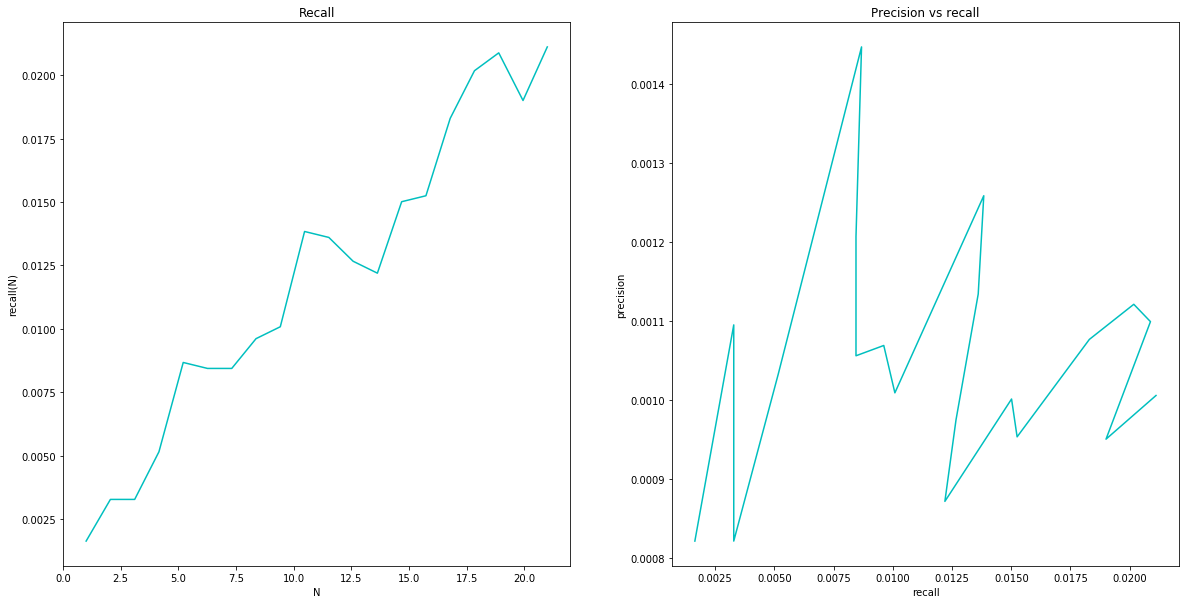

In [110]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
ax.plot(np.linspace(1,21,num=20), rec, 'c-')
ax.set_xlabel('N')
ax.set_ylabel('recall(N)')
ax.set_title('Recall')

ax = plt.subplot(1,2,2)
ax.plot(rec, prec, 'c-')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_title('Precision vs recall')

plt.plot()